In [2]:
# for data
import json

import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for deep learning
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Permute, multiply, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# for bert language model
import transformers


In [3]:
# GPU optimization stuff

import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
tf.compat.v1.disable_eager_execution()


In [4]:
# constants

DATA_PATH = 'data/'
MODEL_PATH = 'models/'

### Read prepared datasets

In [4]:
# split dataset
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

print(df_train.head())

# get X
X_train = df_train['text'].values
X_test = df_test['text'].values

# get target
y_train = df_train["y"].values
y_test = df_test["y"].values


                                                text  y
0  make tea water taste amazing 0 calorie great w...  1
1                                   delicious cheese  1
2                                   love go like mad  1
3      great candy bar wedding reception guest loved  1
4                                            delious  1


### Load prepared word embeddings

In [5]:
emb = json.load(open(DATA_PATH + 'words_emb.json'))

emb_matrix = np.array(list(emb.values()))
words = list(emb.keys())

MAX_LEN = 30

embedding_layer = Embedding(input_dim=emb_matrix.shape[0], output_dim=emb_matrix.shape[1], weights=[
                            emb_matrix], input_length=MAX_LEN, trainable=False)


### Define Bi-directional LSTM model

In [6]:
# code attention layer
def attention_layer(inputs, neurons):
    X = Permute((2, 1))(inputs)
    X = Dense(neurons, activation="softmax")(X)
    X = Permute((2, 1), name="attention")(X)
    X = multiply([inputs, X])

    return X


# model
def bid_lstm(input_shape):
    # input
    X_indices = Input(input_shape)

    # embedding
    embeddings = embedding_layer(X_indices)

    # apply attention
    X = attention_layer(embeddings, neurons=MAX_LEN)

    # 2 layers of bidirectional lstm
    X = Bidirectional(LSTM(
        units=MAX_LEN, dropout=0.2, return_sequences=True))(X)
    X = Bidirectional(LSTM(units=MAX_LEN, dropout=0.2))(X)

    # final dense layers
    X = Dense(64, activation='relu')(X)
    y_out = Dense(1, activation='sigmoid')(X)

    # compile
    model = Model(inputs=X_indices, outputs=y_out)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    return model


model = bid_lstm((MAX_LEN,))

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 300)      12585300    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 30)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 30)      930         ['permute[0][0]']                
                                                                                              

### Training

In [8]:
# tokenizing  sequences from training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_indices = tokenizer.texts_to_sequences(X_train)

# padding sequences to uniform length
X_train_indices = pad_sequences(X_train_indices, maxlen=MAX_LEN)


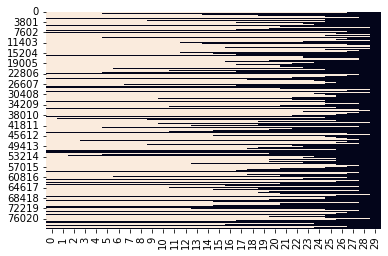

In [9]:
# visualize feature matrix
sns.heatmap(X_train_indices == 0, vmin=0, vmax=1, cbar=False)
plt.show()


In [10]:
# early stopping and model checkpoints

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
bst_model_path = MODEL_PATH + 'bid_lstm.h5'

model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)


In [13]:
# training

hist = model.fit(X_train_indices, y_train, validation_split=0.2,
                 batch_size=2048, epochs=50, callbacks=[early_stopping, model_checkpoint])


Train on 63852 samples, validate on 15964 samples
Epoch 1/50
63852/63852 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9289

c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


63852/63852 [==============================] - 7s 109us/sample - loss: 0.2242 - accuracy: 0.9289 - val_loss: 0.2202 - val_accuracy: 0.9302
Epoch 2/50
63852/63852 [==============================] - 5s 86us/sample - loss: 0.2201 - accuracy: 0.9289 - val_loss: 0.2158 - val_accuracy: 0.9301
Epoch 3/50
63852/63852 [==============================] - 5s 85us/sample - loss: 0.2175 - accuracy: 0.9289 - val_loss: 0.2127 - val_accuracy: 0.9301
Epoch 4/50
63852/63852 [==============================] - 6s 89us/sample - loss: 0.2168 - accuracy: 0.9290 - val_loss: 0.2158 - val_accuracy: 0.9301
Epoch 5/50
63852/63852 [==============================] - 6s 94us/sample - loss: 0.2151 - accuracy: 0.9294 - val_loss: 0.2090 - val_accuracy: 0.9303
Epoch 6/50
63852/63852 [==============================] - 6s 90us/sample - loss: 0.2143 - accuracy: 0.9289 - val_loss: 0.2123 - val_accuracy: 0.9300
Epoch 7/50
63852/63852 [==============================] - 5s 85us/sample - loss: 0.2133 - accuracy: 0.9292 - val_los

### Evaluation

In [14]:
# preparing sequences from test data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)

X_test_indices = tokenizer.texts_to_sequences(X_test)

# padding sequences to uniform length
X_test_indices = pad_sequences(X_test_indices, maxlen=MAX_LEN)


In [38]:
# loading model
model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

print('best val score: {}'.format(bst_val_score))

# evaluate
scores = model.evaluate(X_test_indices, y_test)

print('Accuracy: %.2f%%' % (scores[1]*100))

best val score: 0.19940009917405815
Accuracy: 92.53%


In [41]:
# test
predictions = model.predict(X_test_indices)
predictions = list(map(lambda x: 1 if x > 0.5 else 0, predictions))


[[    9  1408]
 [   83 18453]]


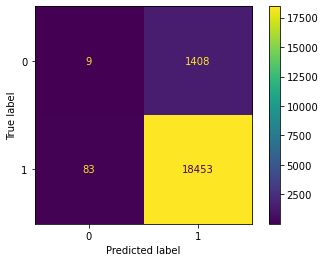

In [42]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

ConfusionMatrixDisplay(conf_matrix).plot()


###

### Transfer-learning with BERT (no pre-processing of text)

In [5]:
import re

from tensorflow.keras import layers, models, optimizers
from sklearn import model_selection


In [6]:
# read tsv into dataframe
dtf = pd.read_csv(DATA_PATH + 'amazon_reviews_grocery_100k.tsv', sep='\t', error_bad_lines=False)

dtf.head


c:\programdata\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1925: expected 15 fields, saw 22\nSkipping line 1977: expected 15 fields, saw 22\nSkipping line 35265: expected 15 fields, saw 22\nSkipping line 53357: expected 15 fields, saw 22\n'
b'Skipping line 68361: expected 15 fields, saw 22\nSkipping line 70922: expected 15 fields, saw 22\nSkipping line 73503: expected 15 fields, saw 22\nSkipping line 85612: expected 15 fields, saw 22\n'


<bound method NDFrame.head of       marketplace  customer_id       review_id  product_id  product_parent  \
0              US     42521656  R26MV8D0KG6QI6  B000SAQCWC       159713740   
1              US     12049833  R1OF8GP57AQ1A0  B00509LVIQ       138680402   
2              US       107642  R3VDC1QB6MC4ZZ  B00KHXESLC       252021703   
3              US      6042304  R12FA3DCF8F9ER  B000F8JIIC       752728342   
4              US     18123821   RTWHVNV6X4CNJ  B004ZWR9RQ       552138758   
...           ...          ...             ...         ...             ...   
98635          US     27635275  R1PHJCOXJ43DD5  B00V3W9SMU       217641189   
98636          US      1369561   R2ESP8RM8ERG4  B00FY2UESM       243349133   
98637          US     49479456  R1VRW0RFCHM8F4  B001L9MQK6       626575660   
98638          US      9965703  R1ZKNAAKDNX73G  B00OX6FIMW       403680832   
98639          US     11372488  R1L2GI2QOIBQJU  B00IN4HABM       974652159   

                                 

In [7]:
# filter columns
dtf = dtf[['review_body', 'star_rating']]

dtf.head


<bound method NDFrame.head of                                              review_body  star_rating
0      As a family allergic to wheat, dairy, eggs, nu...            5
1      My favorite nut.  Creamy, crunchy, salty, and ...            5
2      This green tea tastes so good! My girlfriend l...            5
3      I love Melissa's brand but this is a great sec...            5
4                                                   good            5
...                                                  ...          ...
98635          This was a gift. Exactly what I expected.            5
98636  This is absolutely the most savory brittle I h...            5
98637                              Exactly what I wanted            5
98638                                      Not impressed            1
98639                                             Yummy.            5

[98640 rows x 2 columns]>

In [8]:
# rename columns
dtf = dtf.rename(columns={'review_body': 'text', 'star_rating': 'y'})

dtf.head


<bound method NDFrame.head of                                                     text  y
0      As a family allergic to wheat, dairy, eggs, nu...  5
1      My favorite nut.  Creamy, crunchy, salty, and ...  5
2      This green tea tastes so good! My girlfriend l...  5
3      I love Melissa's brand but this is a great sec...  5
4                                                   good  5
...                                                  ... ..
98635          This was a gift. Exactly what I expected.  5
98636  This is absolutely the most savory brittle I h...  5
98637                              Exactly what I wanted  5
98638                                      Not impressed  1
98639                                             Yummy.  5

[98640 rows x 2 columns]>

In [9]:
# map rating to class (<=1 = 0 | <1 = 1)

dtf['y'] = dtf['y'].map(lambda x: 0 if int(x) <= 1 else 1)

# print 5 random rows
dtf.sample(5)


,text,y
88231,Good product,1
41761,Good price and aside from the packing job prod...,1
39231,Very pleased with the salt. Excellent.,1
25603,Not a quality gourmet popcorn. Full of kernels...,0
23265,Excellent - wish I could find it locally.,1


In [10]:
# split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.2)

# get target
y1_train = dtf_train["y"].values
y1_test = dtf_test["y"].values

In [11]:
# distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    'distilbert-base-uncased', do_lower_case=True)


In [12]:
def prepare_feature_matrix(corpus, maxlen=50):
    # add special tokens
    maxqnans = int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] " +
                        " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '',
                                                    str(txt).lower().strip()))[:maxqnans]) +
                        " [SEP] " for txt in corpus]

    # generate masks
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
        txt.split(" "))) for txt in corpus_tokenized]

    # padding
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" "))
               != maxlen else txt for txt in corpus_tokenized]

    # generate idx
    idx = [tokenizer.encode(seq)[:50] for seq in txt2seq]

    # generate segments
    segments = []
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)

    # feature matrix
    return [np.asarray(idx, dtype='object'),
            np.asarray(masks, dtype='int32'),
            np.asarray(segments, dtype='int32')]


In [13]:
def print_sample(corpus, X):
    i = 0

    print("txt: ", corpus.iloc[0])
    print("tokenized:", [tokenizer.convert_ids_to_tokens(idx)
        for idx in X[0][i].tolist()])
    print("idx: ", X[0][i])
    print("mask: ", X[1][i])
    print("segment: ", X[2][i])


In [14]:
X1_train = prepare_feature_matrix(dtf_train['text'])
X1_test = prepare_feature_matrix(dtf_test['text'])

print_sample(dtf_train['text'], X1_train)

Token indices sequence length is longer than the specified maximum sequence length for this model (2457 > 512). Running this sequence through the model will result in indexing errors


txt:  LOVE THIS FORMULA ! but switched my daughter to lactose free because its better for her(:
tokenized: ['[CLS]', '[CLS]', 'love', 'this', 'formula', 'but', 'switched', 'my', 'daughter', 'to', 'lac', '#', '#', 'to', '##se', 'free', 'because', 'its', 'better', 'for', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
idx:  [101 101 2293 2023 5675 2021 7237 2026 2684 2000 18749 1001 1001 2000 3366
 2489 2138 2049 2488 2005 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
mask:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
segment:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [15]:
# building the model

# inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")

# pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained(
    'distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]

# fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(1, activation='sigmoid')(x)

# compile
model1 = models.Model([idx, masks], y_out)
for layer in model1.layers[:3]:
    layer.trainable = False
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                           

In [16]:
# encode y
dic_y_mapping = {n: label for n, label in enumerate(np.unique(y1_train))}
inverse_dic = {v: k for k, v in dic_y_mapping.items()}
y1_train = np.array([inverse_dic[y] for y in y1_train])


In [15]:
# train
training = model1.fit(x=X1_train, y=y1_train, batch_size=64,
                      epochs=10, shuffle=True, verbose=1, validation_split=0.2)

model1 = model1.save(MODEL_PATH + 'distil_bert.h5')


Train on 63129 samples, validate on 15783 samples
Epoch 1/10
63104/63129 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9286

c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


63129/63129 [==============================] - 73s 1ms/sample - loss: 0.2399 - accuracy: 0.9286 - val_loss: 0.2286 - val_accuracy: 0.9271
Epoch 2/10
63129/63129 [==============================] - 73s 1ms/sample - loss: 0.2189 - accuracy: 0.9294 - val_loss: 0.2345 - val_accuracy: 0.9245
Epoch 3/10
63129/63129 [==============================] - 75s 1ms/sample - loss: 0.2136 - accuracy: 0.9295 - val_loss: 0.2156 - val_accuracy: 0.9266
Epoch 4/10
63129/63129 [==============================] - 74s 1ms/sample - loss: 0.2086 - accuracy: 0.9295 - val_loss: 0.2355 - val_accuracy: 0.9221
Epoch 5/10
63129/63129 [==============================] - 74s 1ms/sample - loss: 0.2074 - accuracy: 0.9302 - val_loss: 0.2058 - val_accuracy: 0.9273
Epoch 6/10
63129/63129 [==============================] - 74s 1ms/sample - loss: 0.2052 - accuracy: 0.9298 - val_loss: 0.2282 - val_accuracy: 0.9274
Epoch 7/10
63129/63129 [==============================] - 78s 1ms/sample - loss: 0.2045 - accuracy: 0.9303 - val_loss

In [16]:
# load model
model1 = models.load_model(MODEL_PATH + 'distil_bert.h5', custom_objects={
                           'TFDistilBertModel': transformers.TFDistilBertModel})

# unfreeze and fine-tune
for layer in model1.layers[:3]:
    layer.trainable = True
model1.compile(loss='binary_crossentropy',
               optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
model1.summary()

fine_tuning = model1.fit(x=X1_train, y=y1_train, batch_size=64,
                         epochs=5, shuffle=True, verbose=1, validation_split=0.2)

# save model
model1.save(MODEL_PATH + 'distil_bert.h5')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                           

c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


63129/63129 [==============================] - 179s 3ms/sample - loss: 0.1990 - accuracy: 0.9307 - val_loss: 0.1757 - val_accuracy: 0.9354
Epoch 2/5
63129/63129 [==============================] - 179s 3ms/sample - loss: 0.1605 - accuracy: 0.9391 - val_loss: 0.1681 - val_accuracy: 0.9389
Epoch 3/5
63129/63129 [==============================] - 180s 3ms/sample - loss: 0.1464 - accuracy: 0.9436 - val_loss: 0.1637 - val_accuracy: 0.9404
Epoch 4/5
63129/63129 [==============================] - 180s 3ms/sample - loss: 0.1340 - accuracy: 0.9473 - val_loss: 0.1674 - val_accuracy: 0.9383
Epoch 5/5
63129/63129 [==============================] - 180s 3ms/sample - loss: 0.1248 - accuracy: 0.9511 - val_loss: 0.1759 - val_accuracy: 0.9410


In [17]:
# load model
model1 = models.load_model(MODEL_PATH + 'distil_bert.h5', custom_objects={
                           'TFDistilBertModel': transformers.TFDistilBertModel})

# evaluate
scores = model1.evaluate(X1_test, y1_test)

print('Accuracy: %.2f%%' % (scores[1]*100))

# test
predicted = model1.predict(X1_test)
predicted = list(map(lambda x: 1 if x > 0.5 else 0, predicted))


c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy: 94.69%


c:\programdata\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[  480   904]
 [  144 18200]]


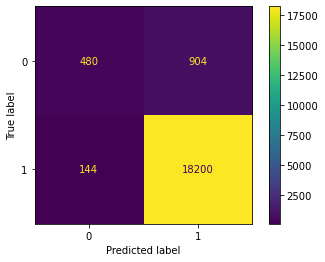

In [19]:
# confusion matrix
conf_matrix = confusion_matrix(y1_test, predicted)
print(conf_matrix)

ConfusionMatrixDisplay(conf_matrix).plot()
